In [2]:
!pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 485.4/485.4 kB 15.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 9.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 12.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 18.2 MB/s eta 0:00:00


In [3]:
#============================ Loading required libraries ============================#

import warnings
warnings.filterwarnings("ignore")



import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import seaborn as sns
import tensorflow as tf
import torch
from torch.utils.data import DataLoader, Dataset

import nltk
nltk.download('punkt')
nltk.download('stopwords')

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
import re

from datasets import load_dataset, DatasetDict
from transformers import AutoTokenizer,TFAutoModelForSequenceClassification
from transformers import BertTokenizer, BertForSequenceClassification, AdamW
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import classification_report, confusion_matrix

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [4]:
# Mounting Google Drive - Only for Google Colab
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
#============================ Read Preprocessed Data ============================#

#df = pd.read_csv('/content/drive/MyDrive/preprocessed_data.csv')
df = pd.read_csv('preprocessed_data.csv')
df['clean_tweet'] = df['clean_tweet'].astype(str)
df['tweet'] = df['tweet'].astype(str)

tweets = list(df['tweet'])
clean_tweets = list(df['clean_tweet'])
labels = list(df['label'])

df

,tweet,clean_tweet,label
0,!!! RT @mayasolovely: As a woman you shouldn't...,woman shouldnt complain clean hous man alway t...,0
1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...,boy dat coldtyga dwn bad cuffin dat hoe 1st place,1
2,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...,dawg ever fuck bitch start cri confus shit,1
3,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...,look like tranni,1
4,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...,shit hear might true might faker bitch told ya,1
...,...,...,...
24778,you's a muthaf***in lie &#8220;@LifeAsKing: @2...,muthaf * * * lie right hi tl trash mine bibl s...,1
24779,"you've gone and broke the wrong heart baby, an...",youv gone broke wrong heart babi drove redneck...,0
24780,young buck wanna eat!!.. dat nigguh like I ain...,young buck wan na eat dat nigguh like aint fuc...,1
24781,youu got wild bitches tellin you lies,youu got wild bitch tellin lie,1


In [6]:
#============================ Tokenization ============================#

# Split into training, validation and test sets
train_texts, test_texts, train_labels, test_labels = train_test_split(clean_tweets, labels, test_size=0.2, random_state=42)
train_texts, val_texts, train_labels, val_labels = train_test_split(train_texts, train_labels, test_size=0.2, random_state=42)

# Loading pre-trained BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Tokenize
train_encodings = tokenizer(train_texts, truncation=True, padding=True)
val_encodings = tokenizer(val_texts, truncation=True, padding=True)
test_encodings = tokenizer(test_texts, truncation=True, padding=True)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [7]:
#============================ Defining a PyTorch Dataset ============================#

class CustomDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

train_dataset = CustomDataset(train_encodings, train_labels)
val_dataset = CustomDataset(val_encodings, val_labels)
test_dataset = CustomDataset(test_encodings, test_labels)

In [8]:
#============================ Loading the pre-trained Model ============================#

model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)

# Defining optimizer
optimizer = AdamW(model.parameters(), lr=1e-5)

# Defining data loaders
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

# Training loop
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [9]:
#============================ Fine-tuning Model ============================#

for epoch in range(3):
    model.train()
    for batch in train_loader:
        optimizer.zero_grad()
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        loss.backward()
        optimizer.step()

    # Validation loop
    model.eval()
    val_accuracy = 0
    with torch.no_grad():
        for batch in val_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            outputs = model(input_ids, attention_mask=attention_mask)
            predictions = torch.argmax(outputs.logits, dim=1)
            val_accuracy += torch.sum(predictions == labels).item() / labels.size(0)

    avg_val_accuracy = val_accuracy / len(val_loader)
    print(f'Epoch {epoch + 1}, Validation Accuracy: {avg_val_accuracy}')


Epoch 1, Validation Accuracy: 0.9642137096774194
Epoch 2, Validation Accuracy: 0.9637096774193549
Epoch 3, Validation Accuracy: 0.9614415322580645


In [10]:
#============================ Evaluating Model Performance ============================#

true_labels = []
predicted_labels = []

# Evaluation loop
model.eval()
with torch.no_grad():
    for batch in test_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        outputs = model(input_ids, attention_mask=attention_mask)
        predictions = torch.argmax(outputs.logits, dim=1)
        true_labels.extend(labels.cpu().numpy())
        predicted_labels.extend(predictions.cpu().numpy())


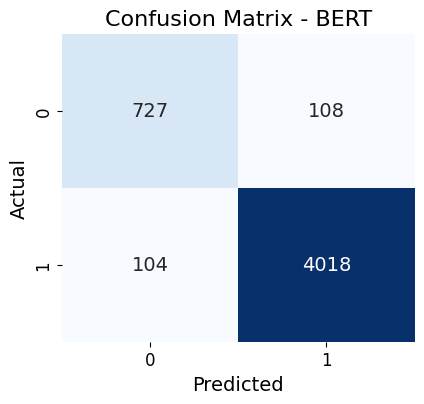


Classification Report:

                precision    recall  f1-score   support

  Appropriate       0.87      0.87      0.87       835
Inappropriate       0.97      0.97      0.97      4122

     accuracy                           0.96      4957
    macro avg       0.92      0.92      0.92      4957
 weighted avg       0.96      0.96      0.96      4957


Evaluation Metrics:

Accuracy: 0.9572321968932822
Precision: 0.9738245273873001
Recall: 0.9747695293546822
F1-score: 0.9742967992240543


In [11]:
# Confusion Matrix
cm = confusion_matrix(true_labels, predicted_labels)
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, annot_kws={"size": 14})
plt.title('Confusion Matrix - BERT', fontsize = 16)
plt.xlabel('Predicted', fontsize = 14)
plt.ylabel('Actual', fontsize = 14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()


# Classification report
target_names = ['Appropriate', 'Inappropriate']
print('\nClassification Report:\n\n', classification_report(true_labels, predicted_labels, target_names=target_names))

# Evaluation Metrics
accuracy = accuracy_score(true_labels, predicted_labels)
precision = precision_score(true_labels, predicted_labels)
recall = recall_score(true_labels, predicted_labels)
f1 = f1_score(true_labels, predicted_labels)
print("\nEvaluation Metrics:\n")
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)

In [18]:
import os

# Create the directories if they do not exist
os.makedirs('/content/drive/MyDrive/bert_model', exist_ok=True)
os.makedirs('/bert_model', exist_ok=True)

# Now save
model.save_pretrained('/content/drive/MyDrive/bert_model')
model.save_pretrained('/bert_model')


In [15]:
#============================ Prediction ============================#

import torch
from transformers import BertForSequenceClassification
from transformers import BertTokenizer, BertForSequenceClassification

#Text Preprocessing

stop_words = set(stopwords.words('english'))
stop_words.add("rt") # adding rt to remove retweet in dataset

# Removing Emojis
def remove_entity(raw_text):
    entity_regex = r"&[^\s;]+;"
    text = re.sub(entity_regex, "", raw_text)
    return text

# Replacing user tags
def change_user(raw_text):
    regex = r"@([^ ]+)"
    text = re.sub(regex, "", raw_text)
    return text

# Removing URLs
def remove_url(raw_text):
    url_regex = r"(?i)\b((?:https?://|www\d{0,3}[.]|[a-z0-9.\-]+[.][a-z]{2,4}/)(?:[^\s()<>]+|\(([^\s()<>]+|(\([^\s()<>]+\)))*\))+(?:\(([^\s()<>]+|(\([^\s()<>]+\)))*\)|[^\s`!()\[\]{};:'\".,<>?«»“”‘’]))"
    text = re.sub(url_regex, '', raw_text)
    return text

# Removing Unnecessary Symbols
def remove_noise_symbols(raw_text):
    text = raw_text.replace('"', '')
    text = text.replace("'", '')
    text = text.replace("!", '')
    text = text.replace("`", '')
    text = text.replace("..", '')
    text = text.replace(".", '')
    text = text.replace(",", '')
    text = text.replace("#", '')
    text = text.replace(":", '')
    text = text.replace("?", '')
    return text

# Stemming
def stemming(raw_text):
    stemmer = PorterStemmer()
    words = [stemmer.stem(word) for word in raw_text.split()]
    return ' '.join(words)

# Removing stopwords
def remove_stopwords(raw_text):
    tokenize = word_tokenize(raw_text)
    text = [word for word in tokenize if not word.lower() in stop_words]
    text = ' '.join(text)
    return text

def preprocess(data):
    clean = []
    clean = [text.lower() for text in data]
    clean = [change_user(text) for text in clean]
    clean = [remove_entity(text) for text in clean]
    clean = [remove_url(text) for text in clean]
    clean = [remove_noise_symbols(text) for text in clean]
    clean = [stemming(text) for text in clean]
    clean = [remove_stopwords(text) for text in clean]

    return clean

In [17]:
import nltk
nltk.download('punkt_tab')
  #model = BertForSequenceClassification.from_pretrained('/content/drive/MyDrive/bert_model/')
model = BertForSequenceClassification.from_pretrained('/bert_model/')
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

custom_input_text = "Kill Yourself!!"

custom_text_list = [custom_input_text]
preprocessed_custom_text = preprocess(custom_text_list)[0]

tokenized_input = tokenizer(preprocessed_custom_text, return_tensors='pt')
output = model(**tokenized_input)
logits = output.logits
probabilities = torch.softmax(logits, dim=1)
predicted_label = torch.argmax(probabilities, dim=1).item()

probability_class_0 = probabilities[0][0].item()
probability_class_1 = probabilities[0][1].item()

print("Predicted Label:", predicted_label)
print("Probability for Class 0:", probability_class_0)
print("Probability for Class 1:", probability_class_1)

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


Predicted Label: 1
Probability for Class 0: 0.29078948497772217
Probability for Class 1: 0.7092105150222778
